In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

dataframe = pd.read_csv('imdb_movie_data.csv')

label_converter = LabelEncoder()
dataframe['encoded_label'] = label_converter.fit_transform(dataframe['Rating Category'])

text_data = dataframe['Description']
rating_data = dataframe['encoded_label']

train_texts, test_texts, train_labels, test_labels = train_test_split(text_data, rating_data, test_size=0.3)

vectorizer = CountVectorizer(max_features=3250)
train_features = vectorizer.fit_transform(train_texts).toarray()
test_features = vectorizer.transform(test_texts).toarray()

train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
test_features_tensor = torch.tensor(test_features, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels.values, dtype=torch.long)

train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
train = DataLoader(train_dataset, batch_size=8)

test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)
test = DataLoader(test_dataset, batch_size=8)

class Classification(nn.Module):
    def __init__(self, first_dimension, second_dimension, count):
        super(Classification, self).__init__()
        self.lstm_layer = nn.LSTM(first_dimension, second_dimension, batch_first = True)
        self.next_layer = nn.Linear(second_dimension, count)

    def forward(self, x):
        x = x.unsqueeze(1)
        lstm_out, (second, _) = self.lstm_layer(x)
        output = self.next_layer(second[0])
        return output

first_dimension = train_features.shape[1]
count = len(label_converter.classes_)
second_dimension = 130

model = Classification(first_dimension, second_dimension, count)
total_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

loss_history = []
accuracy_history = []

num_epochs = 8
for epoch in range(num_epochs):
    model.train()
    correct_predictions = 0
    total_samples = 0
    loss_epoch = 0
    for feature_batch, label_batch in train:
        optimizer.zero_grad()
        predictions = model(feature_batch)
        loss = total_loss(predictions, label_batch)
        loss.backward()
        optimizer.step()
        loss_epoch += loss.item()
        predicted_classes = predictions.argmax(dim=1)
        correct_predictions += (predicted_classes == label_batch).sum().item()
        total_samples += label_batch.size(0)

    average_loss = loss_epoch / len(train)
    accuracy = correct_predictions / total_samples

    loss_history.append(average_loss)
    accuracy_history.append(accuracy)

    print(f"Epoch {epoch + 1} : Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch 1 : Loss: 0.6826, Accuracy: 0.5866
Epoch 2 : Loss: 0.5497, Accuracy: 0.7182
Epoch 3 : Loss: 0.2647, Accuracy: 0.9399
Epoch 4 : Loss: 0.0764, Accuracy: 0.9943
Epoch 5 : Loss: 0.0253, Accuracy: 1.0000
Epoch 6 : Loss: 0.0118, Accuracy: 1.0000
Epoch 7 : Loss: 0.0069, Accuracy: 1.0000
Epoch 8 : Loss: 0.0045, Accuracy: 1.0000


In [2]:
model.eval()

labels = []
predictions = []

with torch.no_grad():
    for feature, label in test:
        prediction = model(feature)
        predicted_classes = prediction.argmax(dim=1)

        predictions.extend(predicted_classes.cpu().numpy())
        labels.extend(label.cpu().numpy())

accuracy = accuracy_score(labels, predictions)
print(f"Test Accuracy: {accuracy:.4f}")
print(classification_report(labels, predictions, target_names=label_converter.classes_))


Test Accuracy: 0.5800
              precision    recall  f1-score   support

   Excellent       0.48      0.42      0.45       122
        Good       0.63      0.69      0.66       178

    accuracy                           0.58       300
   macro avg       0.56      0.55      0.55       300
weighted avg       0.57      0.58      0.57       300



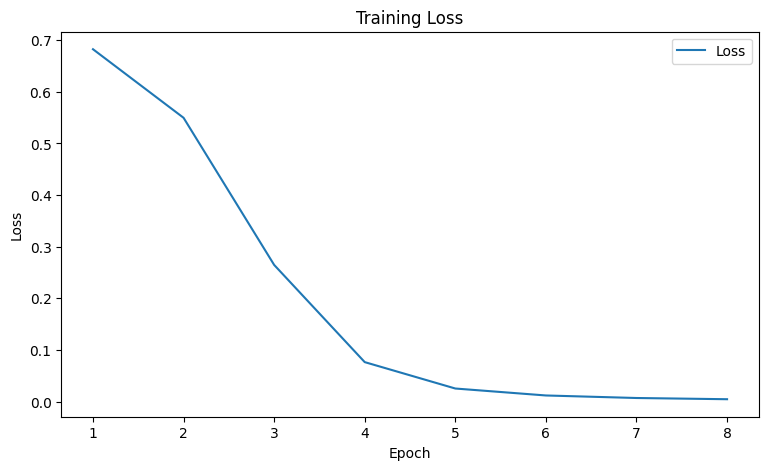

In [3]:
plt.figure(figsize=(9, 5))
plt.plot(range(1, num_epochs + 1), loss_history, label="Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

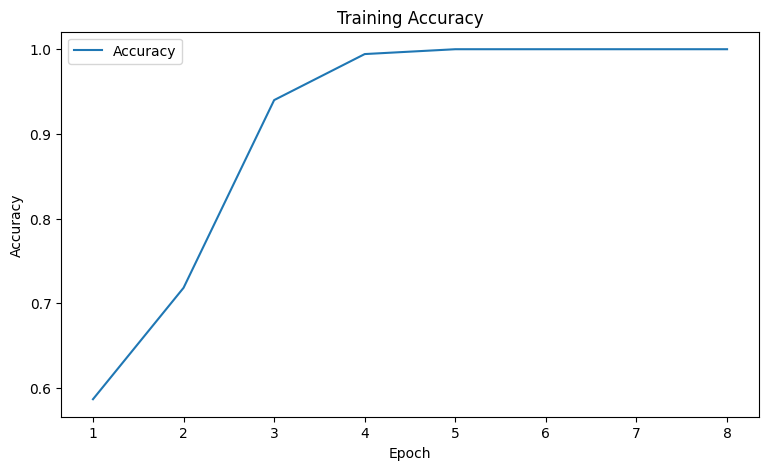

In [4]:
plt.figure(figsize=(9, 5))
plt.plot(range(1, num_epochs + 1), accuracy_history, label="Accuracy")
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()